# Multistage Neural Network
Aravind Kavuturu, June 2024, Johns Hopkins University

## Introduction
This notebook is a reproduction of the codebase found at https://github.com/YaoGroup/MultistageNN, based on the paper, "Multi-stage neural networks: Function approximator of machine precision" by Yongji Wang and Ching-Yao Lai. "Multi-stage neural networks: Function approximator of machine precision" authored by Yongji Wang and Ching-Yao Lai.

The code has been reproduced using Pytorch with modern features for train/optimize loops.

### Libraries
The main library used in this project is Pytorch, with NumPy and MatPlotLib used for utility.

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

### Main Classes

The two main classes implemented for replicating the original framework are a Linear layer class, and a NeuralNetStage class. The NeuralNetStage is analogous to the "PhysicsInformedNN" in the Regression section of the reference codebase. Each NeuralNetStage is comprised of 5 layers of nodes (or 4 layers of weights), with three hidden layers of equal size, and the input/output layers of equal size.

The Linear layer starts with Xavier normal distributed weights and zeroed biases. The activation functions applied to each layer vary based on the stage and layer number, and the value of the weight scale factor $\kappa$ also varies similarly. The forward pass is a simple linear combination: $$\hat{y} = \kappa * (\textbf{X} \cdot \textbf{W}) + \textbf{b}$$ An activation function of either $\sin$, $\tanh$, or no activation is chosen based on layer and stage position. 

The train loop uses an Adam optimizer with mean squared error as the loss criterion. This is the portion of code that varies most with the original codebase, as it is the modern equivalent to the `adam_function` and `minimize` combination used previously.

In [2]:
''' 
Linear Module implements a single layer of a stage in the Multistage Neural Network

Weights are initialized using Xavier normal distribution, and biases are initialized at zero

Activation function is chosen by:
- If it is the first layer and not the first stage, we use a sin activation
- If it is the last layer of any stage, we use no activation function
- Otherwise, we use a tanh activation function
'''
class Linear(nn.Module):
    def __init__(self, layer_num, in_dim, out_dim, act=0, kappa=1):
        # use nn.Module initialization
        super(Linear, self).__init__() 

        # initialize weights as nn.Parameter with Xavier Normal distribution
        self.weight = nn.Parameter(torch.zeros(in_dim, out_dim, dtype=torch.float64, requires_grad=True))
        xavier = np.sqrt(2 / (in_dim + out_dim))
        nn.init.trunc_normal_(self.weight, mean=0.0, std=xavier, a=-2.0*xavier, b=2.0*xavier)

        # initialize biases as nn.Parameter of all zeros
        self.bias = nn.Parameter(torch.zeros(1, out_dim, dtype=torch.float64, requires_grad=True))

        # metadata on current Linear layer
        self.layer_num = layer_num
        self.kappa = kappa
        if act == 0: self.act = torch.tanh
        elif act == 1: self.act =  torch.sin
        else: self.act = None

    # Forward pass function used in computing outputs
    def forward(self, x):
        # kappa * (x @ W) + b
        # use kappa when applicable (first linear layer of each stage)
        self.out = self.kappa * torch.matmul(x, self.weight) + self.bias

        # use activation function when applicable (all layers but the last of each stage)
        if self.act != None: self.out = self.act(self.out)
        return self.out
    
    # reset parameters of model to initial distributions for retraining/debugging
    def reset_parameters(self):
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

'''
NeuralNetStage is the implementation of a single stage of the Multistage Neural Net (MSNN) architecture
'''
class NeuralNetStage(nn.Module):
    def __init__(self, stage_num, reg_dim, n_hidden, kappa=1):
        # use nn.Module initializiation
        super(NeuralNetStage, self).__init__()

        # init metadata for stage
        self.stage_num = stage_num
        self.act = 0 if stage_num == 1 else 1

        # neural net architecture of four sequential linear layers
        self.layers = nn.Sequential(Linear(1, reg_dim, n_hidden, self.act, kappa), 
                        Linear(2, n_hidden, n_hidden), 
                        Linear(3, n_hidden, n_hidden),
                        Linear(4, n_hidden, reg_dim, act=2))
    
    # invoke each layer's forward pass function sequentially
    def forward(self, x):
        self.out = self.layers(x)
        return self.out

    # helper function to reset parameters of every layer
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    # Main training loop
    def train(self, x_train, y_train, lr, itr):
        # initialize optimizer as Adam with learning rate = lr and loss criterion as Mean Squared Error
        optim = torch.optim.Adam(self.parameters(), lr)
        criterion = nn.MSELoss()
        self.scale = torch.max(torch.abs(y_train)) / 2
        y_train /= self.scale

        # loop data (loss accumulator, max iterations) + reset parameters before training
        lossi = []
        print(f"Stage {self.stage_num} Training:")
        
        # train loop
        for i in range(itr):
            # initialize inputs/labels as pytorch variables
            inputs = Variable(x_train)
            labels = Variable(y_train)

            # zero all gradients in weights
            optim.zero_grad()

            # compute output logits from neural net forward pass
            outputs = self(inputs)

            # compute MSE loss and backpropagate loss from gradients
            loss = criterion(outputs, labels)
            loss.backward()

            # step optimizer
            optim.step()

            # print current loss every 1000 iterations
            if i % 100 == 0:
                print(f'{i:7d}/{itr:4d}: {loss.item() * (self.scale ** 2)}')
                
            lossi.append(loss.item())
    
    # Main prediction loop
    def predict(self, x_train):
        # ensure pytorch doesn't compute any gradients
        with torch.no_grad():
            y_pred = self(Variable(x_train))
        
        # predict from network output and return numpy array of estimate
        return y_pred.detach() * self.scale
    
    # helper function to find number of zeros for computing next stage's kappa value
    def find_zeros(self, diff):
        idx_zero = np.where(diff[0:-1, 0] * diff[1:, 0] < 0)[0]
        num_zeros = idx_zero.shape[0]
        return num_zeros
    
    # helper function to compute H for first layer's forward pass (data preprocessing step)
    def compute_H(self, lx, ux, x):
        self.H = 2.0 * (x - lx) / (ux - lx) - 1.0
        self.H = self.H.type(torch.float64)
        return self.H


### Data Initialization

The data is split to train and eval for the input function to approximate, `func`. The input features `x_train` are scaled by $\frac12 \max(|x\_train|)$ and are further normalized using the upper and lower bounds `lx` and `ux`.

In [3]:
np.random.seed(234)
gen = torch.manual_seed(234)
N_eval = 8000

# define test function to approximate
def func(x):
    y = (1 - (x**2) / 2) * np.cos(30*(x + 0.5*(x ** 3)))
    return y

# train dataset for training first stage
# x = inputs, y = labels
x_train_np = np.linspace(-1.02, 1.02, N_eval, dtype=np.float64)[:, None]
x_train = torch.from_numpy(x_train_np)
y_train = func(x_train)

# lower/upper bounds on x values used for normalizing when computing H
lx = x_train_np.min(0)
ux = x_train_np.max(0)

# increase number of datapoints from 1501 to 4801 for third/fourth stage -> x_train2
x_train_4801_np = np.linspace(-1.02, 1.02, 4801, dtype=np.float64)[:, None]
x_train_4801 = torch.from_numpy(x_train_4801_np)
y_train_4801 = func(x_train_4801)

# eval dataset for validation
x_eval_np = np.linspace(-1, 1, N_eval, dtype=np.float64)[:, None]
x_eval = torch.from_numpy(x_eval_np)
y_eval = func(x_eval)

### Stage Trainings

Each stage is initialized by the number of input features (1D equations have `reg_dim = 1`, 2D `=2`, etc.) and number of hidden nodes in each hidden layer. This number increases from 20 to 30 after the second stage. Additionally, the number of datapoints increases from 1501 to 4801 after the second stage.

$\kappa$ is found from the number of zeros of the input dataset - in future work, this can be changed to incorporate the dominant frequency instead, as mentioned in the paper.

`H` is the normalized input to the neural network, copying from the original codebase.


In [4]:
# reg_dim is dimensionality of func
reg_dim = 1
n_hidden1 = 20
n_hidden2 = 30
lr = 1e-4

'''First Stage Training'''

kappa1 = 1
stage1 = NeuralNetStage(1, reg_dim, n_hidden1, kappa1)
H1 = stage1.compute_H(lx, ux, x_train)

stage1.train(H1, y_train, lr, itr=7000)
y_pred = stage1.predict(x_eval)

'''Second Stage Training'''
y_train2 = y_train - stage1.predict(x_train)
kappa2 = 3 * stage1.find_zeros(y_train2)

stage2 = NeuralNetStage(2, reg_dim, n_hidden1, kappa2)
H2 = stage2.compute_H(lx, ux, x_train)

stage2.train(H2, y_train2, lr, itr=10000)
y_pred2 = stage2.predict(x_eval)
y_p = y_pred + y_pred2

'''Third Stage Training'''
y_train3 = y_train - stage1.predict(x_train) - stage2.predict(x_train)
kappa3 = 3 * stage2.find_zeros(y_train3)

stage3 = NeuralNetStage(3, reg_dim, n_hidden2, kappa3)
H3 = stage3.compute_H(lx, ux, x_train)

stage3.train(H3, y_train3, lr, itr=10000)
y_pred3 = stage3.predict(x_eval)
y_p2 = y_pred + y_pred2 + y_pred3

# '''Fourth Stage Training'''
y_train4 = y_train - stage1.predict(x_train) - stage2.predict(x_train) - stage3.predict(x_train)
kappa4 = 3 * stage3.find_zeros(y_train4)

stage4 = NeuralNetStage(4, reg_dim, n_hidden2, kappa4)
H4 = stage4.compute_H(lx, ux, x_train)

stage4.train(H4, y_train4, lr, itr=10000)
y_pred4 = stage4.predict(x_eval)
y_p3 = y_pred + y_pred2 + y_pred3 + y_pred4

Stage 1 Training:
      0/7000: 0.35342921019826146
    100/7000: 0.35292526950307274
    200/7000: 0.3529210322912371
    300/7000: 0.35291630083393877
    400/7000: 0.3529112156067077
    500/7000: 0.3529057876605177
    600/7000: 0.3529000623853425
    700/7000: 0.35289426435858773
    800/7000: 0.35288890511105225
    900/7000: 0.3528846446115215
   1000/7000: 0.3528818396389834
   1100/7000: 0.3528802550701861
   1200/7000: 0.3528793505122574
   1300/7000: 0.35287872022018074
   1400/7000: 0.3528781891796282
   1500/7000: 0.35287770299333165
   1600/7000: 0.35287724419393585
   1700/7000: 0.35287680351764844
   1800/7000: 0.35287637331954946
   1900/7000: 0.3528759460956595
   2000/7000: 0.3528755136884948
   2100/7000: 0.35287506633558385
   2200/7000: 0.3528745912786664
   2300/7000: 0.35287407057446085
   2400/7000: 0.3528734775188783
   2500/7000: 0.3528727708492085
   2600/7000: 0.3528718861192048
   2700/7000: 0.3528707258371626
   2800/7000: 0.3528691551820893
   2900/7000:

## Plotting Results

The below plots show the results of the regression from the four stage training. The first plot is the target function and the approximation, and each subsequent plot is the residues of the previous plot's first pass approximation.

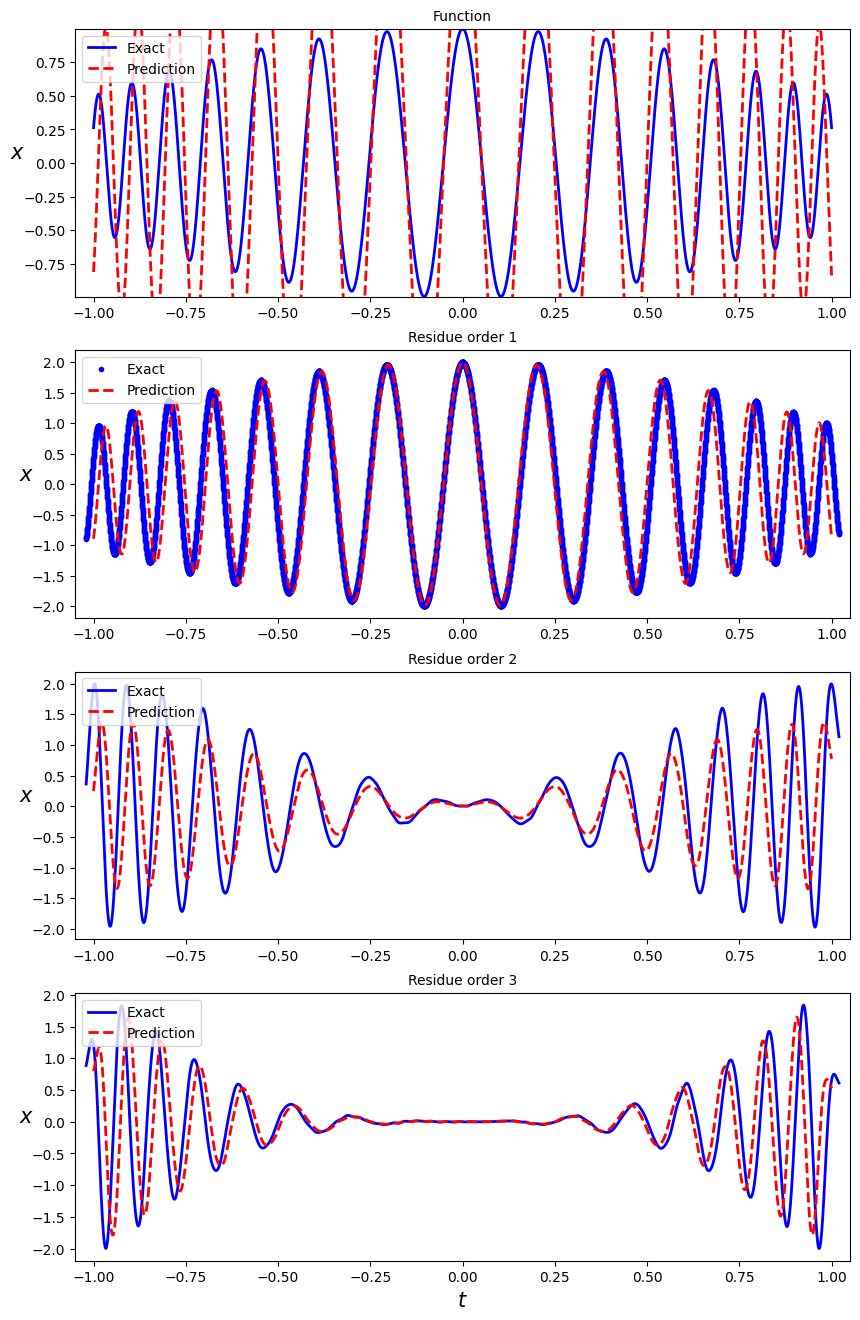

In [5]:
ymin = y_eval.numpy().min()
ymax = y_eval.numpy().max()

fig = plt.figure(figsize=[10, 16], dpi=100)
ax = plt.subplot(411)
ax.plot(x_eval, y_eval, 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_eval, y_p, 'r--', linewidth = 2, label = 'Prediction')
ax.set_ylabel('$x$', fontsize=15, rotation = 0)
ax.set_title('Function', fontsize=10)
ax.set_xlim([-1.05, 1.05])
ax.set_ylim([ymin,ymax])
ax.legend(loc="upper left")

ax1 = plt.subplot(412)
ax1.plot(x_train, y_train2, 'b.', linewidth=2, label='Exact')
ax1.plot(x_eval, y_pred2, 'r--', linewidth=2, label='Prediction')
ax1.set_ylabel('$x$', fontsize=15, rotation=0)
ax1.set_title('Residue order 1', fontsize=10)
ax1.set_xlim([-1.05, 1.05])
ax1.legend(loc="upper left")

ax2 = plt.subplot(413)
ax2.plot(x_train, y_train3, 'b-', linewidth=2, label='Exact')
ax2.plot(x_eval, y_pred3, 'r--', linewidth=2, label='Prediction')
ax2.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax2.set_title('Residue order 2', fontsize = 10)
ax2.set_xlim([-1.05, 1.05])
ax2.legend(loc="upper left")

ax3 = plt.subplot(414)
ax3.plot(x_train, y_train4, 'b-', linewidth = 2, label = 'Exact')
ax3.plot(x_eval, y_pred4, 'r--', linewidth=2, label='Prediction')
ax3.set_xlabel('$t$', fontsize = 15)
ax3.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax3.set_title('Residue order 3', fontsize = 10)
ax3.set_xlim([-1.05, 1.05])
ax3.legend(loc="upper left")